In [1]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2

from PIL import Image
import scipy.misc

Using TensorFlow backend.


In [2]:
cancer_filename = "../CancerMerged.txt"
normal_filename = "../NormalMerged.txt"

cancer_data = pd.read_table(cancer_filename, header=None)
cancer_data_t = cancer_data.T
cancer_data_tmp = cancer_data_t
cancer_data_tmp.columns = cancer_data_tmp.iloc[0]
cData = cancer_data_tmp.drop(0)

normal_data = pd.read_table(normal_filename, header=None)
normal_data_t = normal_data.T
normal_data_tmp = normal_data_t
normal_data_tmp.columns = normal_data_tmp.iloc[0]
nData = normal_data_tmp.drop(0)
nData.shape

(324, 60488)

In [14]:
cData.shape

(3104, 60488)

In [39]:
allData = pd.concat([cData, nData], ignore_index=True)
#d = np.array(allData.values, dtype='float')
dat = allData.values
dat = dat.astype('float32')
dat[np.isnan(dat)] = 0

In [40]:
# Add 12 zero columns
Y_cancer = np.ones(3104)
Y_normal = np.zeros(324)

dat_Y = np.append(Y_cancer, Y_normal)
dat = np.c_[ dat, np.zeros(shape=(dat.shape[0], 12)), dat_Y]

In [41]:
dat.shape

(3428, 60501)

In [43]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(dat, test_size=0.3, random_state=0)

In [44]:
train.shape

(2399, 60501)

In [58]:
x_train = train[:,0:60500]
y_train = train[:,-1]
x_test = test[:,0:60500]
y_test = test[:,-1]

In [54]:
train[1,]

array([ 0.,  4.,  0., ...,  0.,  0.,  1.])

In [57]:
x_train[1,]

1.0

In [59]:
x_train = x_train.reshape(x_train.shape[0], 250, 242, 1)
x_test = x_test.reshape(x_test.shape[0], 250, 242, 1)

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, RepeatVector, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l1, l2


In [12]:
### Model Settings ###
model = Sequential()

model.add( Conv2D(64, 5, kernel_regularizer=l2(.005), padding='same', input_shape=(250,242,1)) )
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(momentum=.9, scale=False))
model.add(Dropout(0.5))
model.add( MaxPooling2D(pool_size=(2,2)))

model.add( Conv2D(64, 5, kernel_regularizer=l2(.005), padding='same') )
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(momentum=.9, scale=False))
model.add(Dropout(0.25))


model.add( Conv2D(32, 5, kernel_regularizer=l2(.005), padding='same') )
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(momentum=.9, scale=False))

model.add( Conv2D(32, 5, kernel_regularizer=l2(.005), padding='same') )
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(momentum=.9, scale=False))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(.005)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(.005)))
model.add(Dense(1, activation='softmax', kernel_regularizer=l2(.005)))


# Define optimizer
optimizer = Adam(lr=0.001)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])



In [60]:
model.fit(x_train, y_train, batch_size=32, epochs=2)
result = model.evaluate(x_test, y_test)
print(result)

Epoch 1/2
2399/2399 [==============================] - 1132s - loss: 1.4812 - acc: 0.9079     

In [61]:
pred_results = model.predict_classes(x_test, batch_size=32, verbose=1)

1029/1029 [==============================] - 158s     

In [67]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes = None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

TypeError: object of type 'NoneType' has no len()

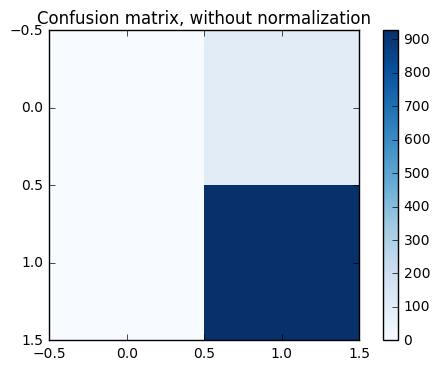

In [69]:
cm=confusion_matrix(y_test, pred_results)

plt.figure()
plot_confusion_matrix(cm, classes=None,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=None, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [72]:
confusion_matrix = cm
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


In [73]:
confusion_matrix.sum(axis=0)

array([   0, 1029])